In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import json
from tqdm import tqdm

In [2]:
device = "cuda:0"
model_path = "LayTextLLM/LayTextLLM-Zero"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code = True, padding_side = 'left')
model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code = True).to(device)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
## model generation setup
generate_params = {
    "use_cache": True,
    "do_sample": False,
    "num_beams": 1,
    "max_new_tokens": 512,
    "min_new_tokens": None,
    "top_p": 0.9,
    "repetition_penalty": 1.0,
    "length_penalty": 1.0,
    "num_return_sequences": 1,
    "temperature": 1.0,
    "output_scores": True,
    "output_hidden_states": True,
    "output_attentions": True,
    "return_dict_in_generate": True,
    "keyword": None
}

In [4]:
BOX_TOKEN = "<unk>"
BOX_TOKEN_ID = 0
INPUT_PROMPT_TEMPLATE = "given document <document>{ocr}</document>, answer following question: {question} Please think step-by-step.\n## answer:"

with open("../datasets/cord_test.json", "r") as fin:
    test_data = json.load(fin)

print('==========num examples', len(test_data))

==========num examples 1071


In [5]:
with torch.no_grad():
    for idx,example in enumerate(tqdm(test_data[2:3])):

        input_ids, input_polys = [], []
        img_size = {}

        texts = example['ocr']
        polys = example['poly']
        w, h = example['img_size']['w'], example['img_size']['h']
        question = example['question']
        answer = example['answer']
        meta = example['metadata']

        ## if ocr is empty, skip this example
        if len(texts) == 0:
            continue

        ## prepare input text ids, and layout polys
        for text, poly in zip(texts, polys):
            input_ids += [BOX_TOKEN_ID]
            text_ids = tokenizer.encode(text, add_special_tokens=False)
            input_ids += text_ids
            text_poly = [poly[0]/w,poly[1]/h,poly[4]/w,poly[5]/h]
            input_polys.append(text_poly)

        # extract layout embeddings
        input_polys = torch.as_tensor(input_polys).unsqueeze(0).to(device)

        # extract text embeddings
        # assign template to input texts
        input_data = {"ocr": tokenizer.decode(input_ids), "question": question}
        input_texts = INPUT_PROMPT_TEMPLATE.format(**input_data)

        # extract text ids
        input_ids = tokenizer.encode(input_texts, add_special_tokens=False)
        input_ids = torch.as_tensor(input_ids).unsqueeze(0).to(device)
        attention_mask = torch.ones_like(input_ids).to(device)

        # Forward pass with attention extraction
        # outputs = model(
        #     input_ids=input_ids,
        #     laytout_input=input_polys,
        #     attention_mask=attention_mask,
        #     output_attentions=True
        #     )
        # attentions = outputs.attentions 

        model_output = model.generate(
                input_ids=input_ids,
                laytout_input=input_polys,
                attention_mask=attention_mask,
                **generate_params
            )

  0%|          | 0/1 [00:00<?, ?it/s]/home/tiger/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


In [6]:
for idx, token_id in enumerate(model_output.sequences[0]):
    print(idx, token_id, tokenizer.decode(token_id))

0 tensor(2183, device='cuda:0') given
1 tensor(1842, device='cuda:0') document
2 tensor(529, device='cuda:0') <
3 tensor(3225, device='cuda:0') document
4 tensor(29958, device='cuda:0') >
5 tensor(0, device='cuda:0') <unk>
6 tensor(29871, device='cuda:0') 
7 tensor(29929, device='cuda:0') 9
8 tensor(29900, device='cuda:0') 0
9 tensor(29896, device='cuda:0') 1
10 tensor(29900, device='cuda:0') 0
11 tensor(29896, device='cuda:0') 1
12 tensor(29953, device='cuda:0') 6
13 tensor(0, device='cuda:0') <unk>
14 tensor(448, device='cuda:0') -
15 tensor(29911, device='cuda:0') T
16 tensor(2965, device='cuda:0') IC
17 tensor(29968, device='cuda:0') K
18 tensor(2544, device='cuda:0') ET
19 tensor(0, device='cuda:0') <unk>
20 tensor(28505, device='cuda:0') CP
21 tensor(0, device='cuda:0') <unk>
22 tensor(29871, device='cuda:0') 
23 tensor(29906, device='cuda:0') 2
24 tensor(0, device='cuda:0') <unk>
25 tensor(29871, device='cuda:0') 
26 tensor(29953, device='cuda:0') 6
27 tensor(29900, device='cuda

In [7]:
for idx, token_id in enumerate(model_output.sequences[0][input_ids.size(1):]):
    print(idx, token_id, tokenizer.decode(token_id))

0 tensor(16696, device='cuda:0') Step
1 tensor(29871, device='cuda:0') 
2 tensor(29896, device='cuda:0') 1
3 tensor(313, device='cuda:0') (
4 tensor(16492, device='cuda:0') Question
5 tensor(24352, device='cuda:0') Analysis
6 tensor(1125, device='cuda:0') ):
7 tensor(450, device='cuda:0') The
8 tensor(1139, device='cuda:0') question
9 tensor(338, device='cuda:0') is
10 tensor(1048, device='cuda:0') about
11 tensor(1820, device='cuda:0') key
12 tensor(29899, device='cuda:0') -
13 tensor(1767, device='cuda:0') value
14 tensor(4805, device='cuda:0') extra
15 tensor(428, device='cuda:0') ction
16 tensor(29889, device='cuda:0') .
17 tensor(1126, device='cuda:0') And
18 tensor(278, device='cuda:0') the
19 tensor(1139, device='cuda:0') question
20 tensor(19514, device='cuda:0') asks
21 tensor(363, device='cuda:0') for
22 tensor(278, device='cuda:0') the
23 tensor(14728, device='cuda:0') quantity
24 tensor(310, device='cuda:0') of
25 tensor(448, device='cuda:0') -
26 tensor(29911, device='cuda

In [8]:
# pip install seaborn

In [9]:
model_output.attentions[2][0][0].shape

torch.Size([32, 1, 162])

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Let's assume you have attention maps for T tokens
max_output_length = model_output.sequences.size(1)  # Number of tokens generated
# max_source_length = input_ids.size(1)+1  # Maximum source sequence length

full_attention_matrices = []

for attention_score in model_output.attentions[len(input_ids):]:
    # Load or extract the attention map for token t
    # Average over heads and layers
    # attention_map = torch.stack(attention_score).cpu().squeeze(1).squeeze(2).mean(dim=(0,1))  # mean of attention of all heads fo the all layers
    attention_map = attention_score[0].cpu().squeeze(0).squeeze(1).max(dim=0)[0] # max of attention of all heads in the first layer
    # attention_map = attention_score[-1].cpu().squeeze(0).squeeze(1).mean(dim=0) # mean of attention of all heads in the first layer


    # Pad to max_source_length
    padded_attention = np.pad(
        attention_map,
        (0, max_output_length - attention_map.shape[0]),
        'constant',
        constant_values=0
    )


    full_attention_matrices.append(padded_attention)

# Stack to form the attention matrix
full_attention_matrix = np.stack(full_attention_matrices, axis=0).T
print(full_attention_matrix.shape)

# Plot the attention matrix
plt.figure(figsize=(100, 200))
sns.heatmap(full_attention_matrix, cmap='viridis', cbar_kws={"shrink": 0.2})
cbar = plt.gcf().axes[-1]  # Get the color bar axis
cbar.tick_params(labelsize=30)  
# Set tick gaps for both x and y axes
# Set tick positions and labels
source_tokens = [tokenizer.decode(input_id) for input_id in model_output.sequences[0]]
target_tokens = [tokenizer.decode(input_id) for input_id in model_output.sequences[0][len(input_ids[0])+1:]]

plt.yticks(ticks=np.arange(0, len(source_tokens)), labels=source_tokens, rotation=0, fontsize=30)
plt.xticks(ticks=np.arange(0, len(target_tokens)), labels=target_tokens, rotation=90,  fontsize=30)
plt.xlabel('Target Token', fontsize=30)
plt.ylabel('Source Token', fontsize=30)
plt.title('LayTextLLM Attention Map', fontsize=30)
plt.savefig("LayTextLLM_Attention_Map.pdf", format="pdf", bbox_inches="tight")
# plt.show()

(327, 166)


In [11]:
input_attention = model_output.attentions[0][0].squeeze(0).max(dim=0)[0]

(20, 15)


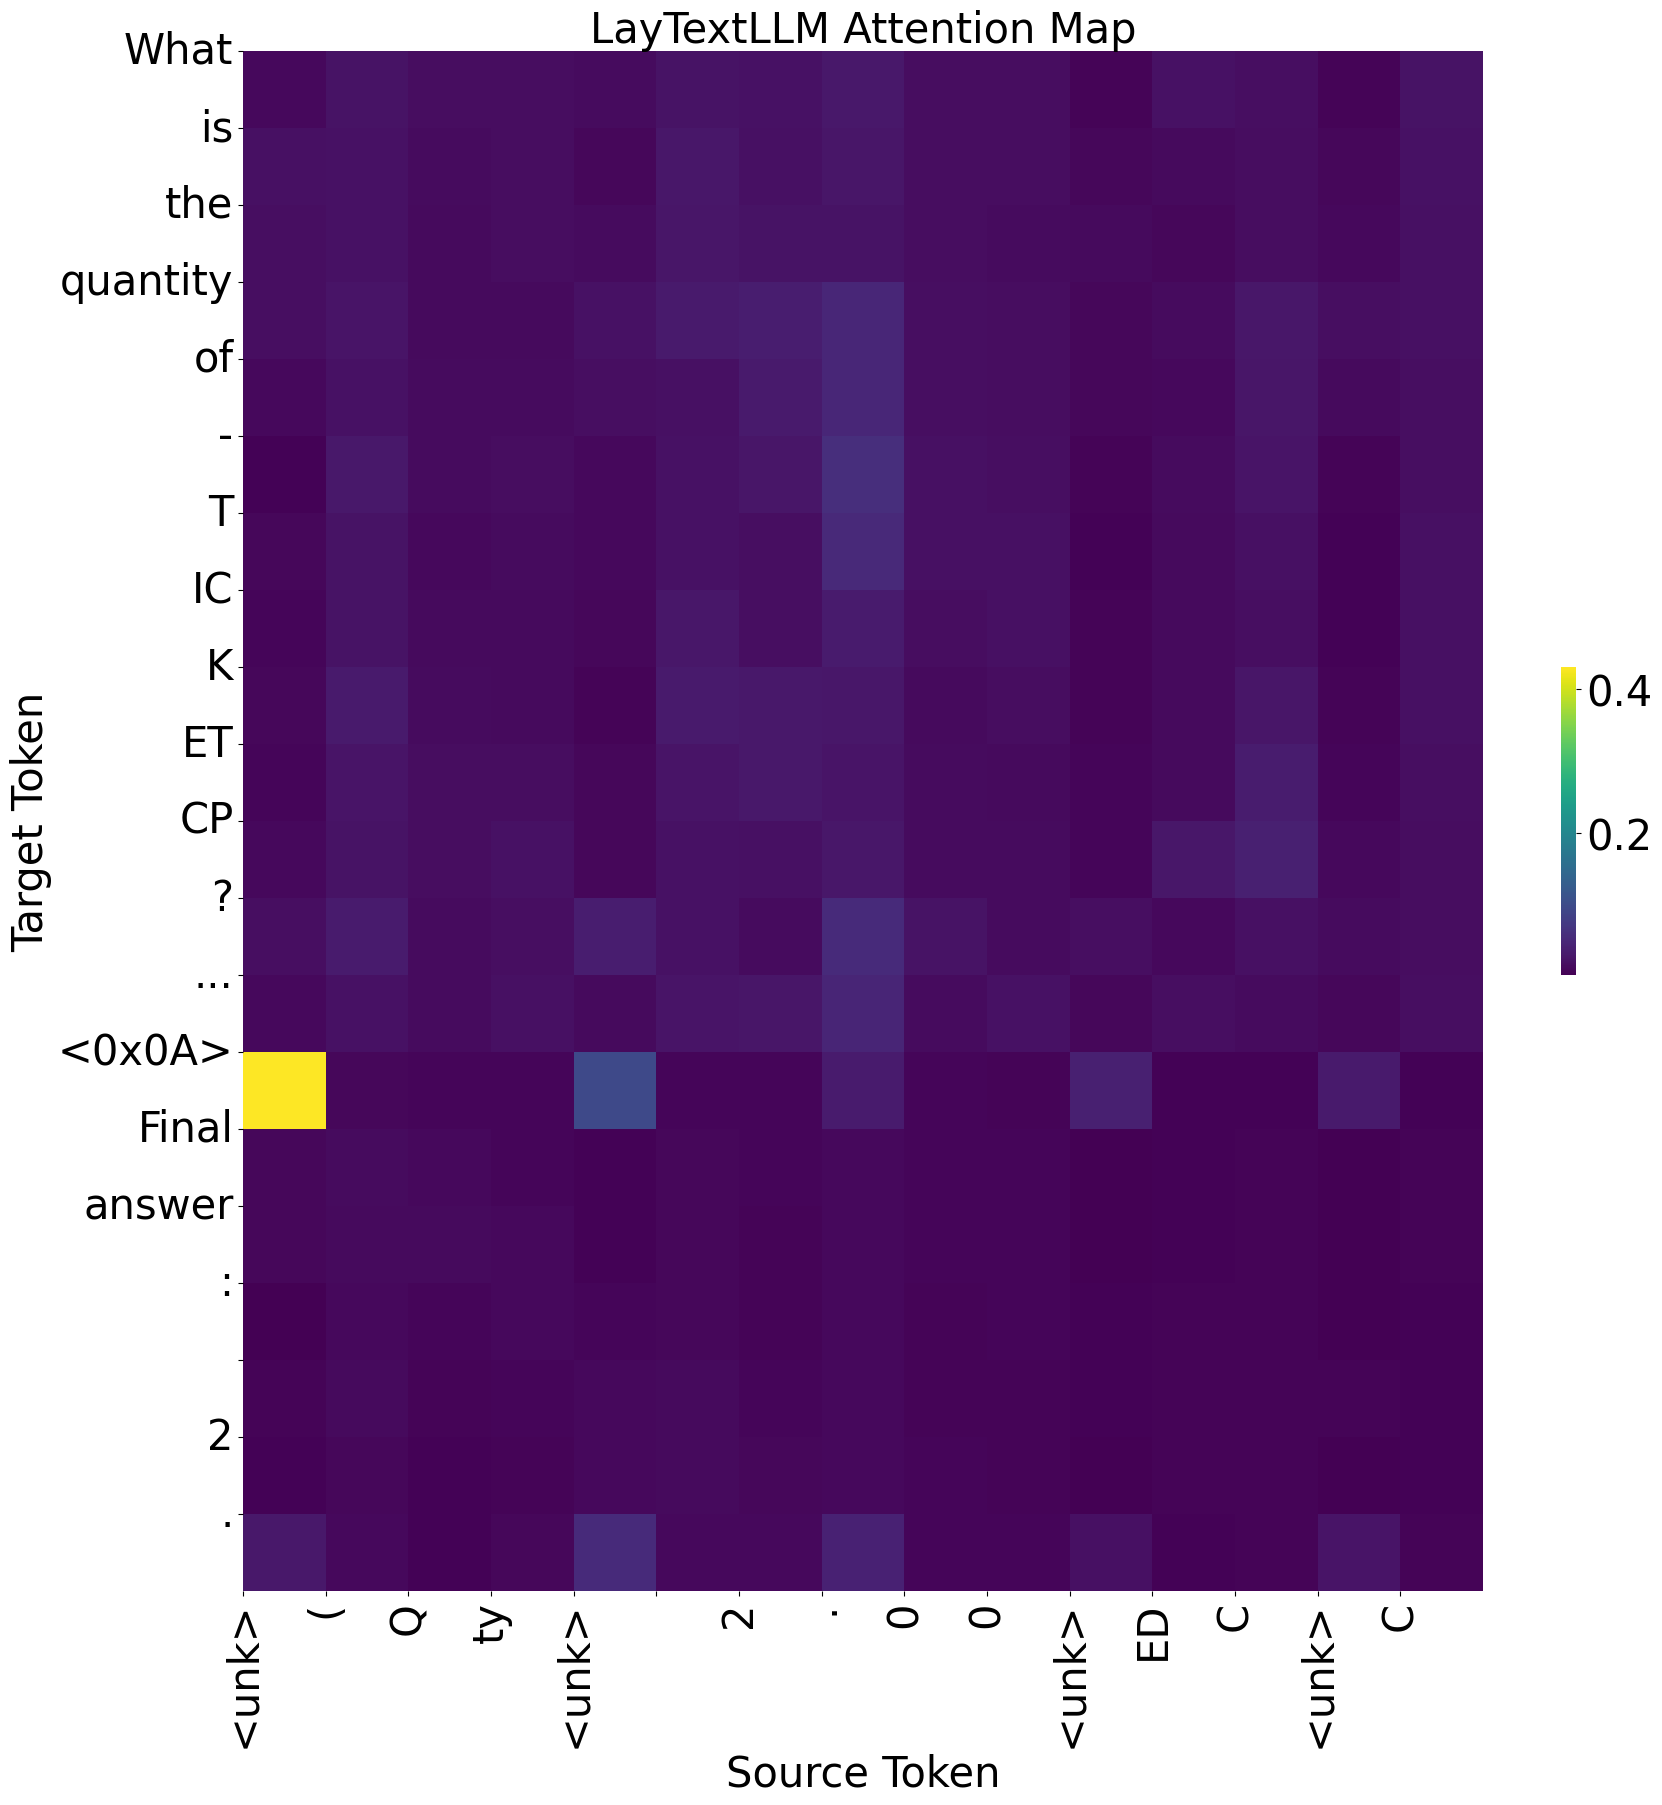

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Let's assume you have attention maps for T tokens
max_output_length = model_output.sequences.size(1)  # Number of tokens generated
# max_source_length = input_ids.size(1)+1  # Maximum source sequence length

attention_matrices = []

for attention_score in model_output.attentions[-20:]:
    # Load or extract the attention map for token t
    # Average over heads and layers
    attention_map = attention_score[0].cpu().squeeze(0).squeeze(1).max(dim=0)[0][90:105] # max of attention of all heads in the first layer


    # Pad to max_source_length
    # padded_attention = np.pad(
    #     attention_map,
    #     (0, max_output_length - attention_map.shape[0]),
    #     'constant',
    #     constant_values=0
    # )


    attention_matrices.append(attention_map)

# Stack to form the attention matrix
attention_matrix = np.stack(attention_matrices, axis=0)

question = "What is the quantity of - TICKET CP? ..."
question_tokens = [tokenizer.decode(token_id) for token_id in tokenizer.encode(question, add_special_tokens=False)]

attention_matrix[:len(question_tokens)] = input_attention[136:149, 90:105].cpu()
print(attention_matrix.shape)

# Plot the attention matrix
plt.figure(figsize=(20, 20))
sns.heatmap(attention_matrix, cmap='viridis', cbar_kws={"shrink": 0.2})
cbar = plt.gcf().axes[-1]  # Get the color bar axis
cbar.tick_params(labelsize=30)  
# Set tick gaps for both x and y axes
# Set tick positions and labels
source_tokens = [tokenizer.decode(input_id) for input_id in model_output.sequences[0]][90:105]

target_tokens = [tokenizer.decode(input_id) for input_id in model_output.sequences[0][-21:-1]]
target_tokens[:len(question_tokens)] = question_tokens

plt.yticks(ticks=np.arange(0, len(target_tokens)), labels=target_tokens, rotation=0, fontsize=30)
plt.xticks(ticks=np.arange(0, len(source_tokens)), labels=source_tokens, rotation=90,  fontsize=30)
plt.xlabel('Source Token', fontsize=30)
plt.ylabel('Target Token', fontsize=30)
plt.title('LayTextLLM Attention Map', fontsize=30)
plt.savefig("LayTextLLM_Attention_Map.pdf", format="pdf", bbox_inches="tight")
# plt.show()


In [13]:
input_attention[136:148].cpu().shape

torch.Size([12, 160])

In [14]:
full_attention_matrix[:][159]

array([0.07538241, 0.06818718, 0.06779607, 0.08731502, 0.06602755,
       0.06653259, 0.0632955 , 0.05952703, 0.05369503, 0.05091999,
       0.0595193 , 0.0706742 , 0.06551313, 0.06071058, 0.05291916,
       0.04343126, 0.06996866, 0.03527139, 0.03359446, 0.03266141,
       0.03165429, 0.02634417, 0.02566027, 0.02516644, 0.02488934,
       0.04148651, 0.02643648, 0.02592546, 0.02344019, 0.02332516,
       0.01921296, 0.01887881, 0.02175388, 0.01714718, 0.01645325,
       0.03089586, 0.02115057, 0.01675514, 0.01637998, 0.0157203 ,
       0.01454132, 0.01473074, 0.01640562, 0.01575292, 0.01462378,
       0.01364576, 0.01325232, 0.01294763, 0.0144656 , 0.01380004,
       0.01400121, 0.01524977, 0.0175685 , 0.01583141, 0.01356346,
       0.01387478, 0.01261407, 0.01255949, 0.01203865, 0.01105624,
       0.0115376 , 0.01520292, 0.01683754, 0.0159619 , 0.0131962 ,
       0.01252811, 0.01408855, 0.01573863, 0.01703302, 0.01544553,
       0.01414337, 0.01459586, 0.01532195, 0.0103112 , 0.01037

In [15]:
vis_attention_score = []
coordinate_idx = 0
## get the attantion score of each coordinate
for token_idx,token_id in enumerate(input_ids[0]):
    if token_id == 0: # placeholder of layout embedding
        vis_attention_score.append(full_attention_matrix[token_idx][159])
        coordinate_idx += 1

Figure size: [6.4 4.8]


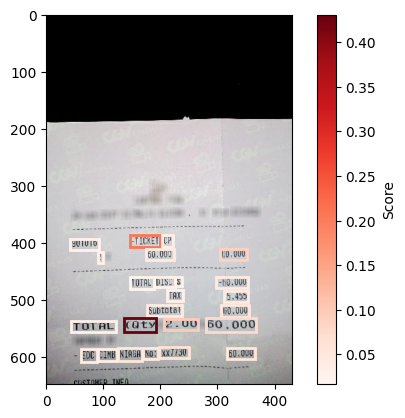

In [16]:
## visualize score
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import matplotlib as mpl


# Load the image
image_path = 'cord_example.jpg'  # Replace with your image path
image = Image.open(image_path)

# Example bounding box data [x, y, width, height, score]
scores = vis_attention_score

# Create figure and axes
fig, ax = plt.subplots(1)
ax.imshow(image)

# Define a colormap to map score to color
cmap = plt.get_cmap('Reds')
norm = mpl.colors.Normalize(vmin=min(scores), vmax=max(scores))
bounding_boxes = polys
# Plot each bounding box
for i, box in enumerate(bounding_boxes):
    x, y, w, h = box[0], box[1], box[4]-box[0], box[5]-box[1]
    score = scores[i]
    
    # Get color based on the score
    color = cmap(norm(score))  # Score between 0 and 1, maps to the colormap
    
    # Create a rectangle patch
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
    
    # Add the rectangle to the plot
    ax.add_patch(rect)
# Create a ScalarMappable for the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set a dummy array for the color bar

# Add color bar with legend
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Score')
# Display the plot
print("Figure size:", fig.get_size_inches())
plt.savefig("cord_example.pdf", format="pdf", bbox_inches="tight")
plt.show()